# MCMC analysis of GU Psc b

In [1]:
#import modules and enable inline plots
import numpy as np
from scipy import stats #For Kernel Density Estimation
from scipy.linalg.lapack import dpotrf
from scipy.linalg.lapack import dpotrs
import matplotlib  #ploting
matplotlib.use("Agg") 
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

In [2]:
import mcmcroutines as mcmc

## read in data

In [491]:
filename='Gu_variab_20141011_J_normlightcurve_GU_comp.txt'
#filename='Gu_variab_20141010_J_normlightcurve_GU_comp.txt'
#filename='Gu_variab_20131222_J_normlightcurve_GU_comp.txt'
data=[]
nd=1 #data column - range is 1-8
f = open(filename, 'r')
for line in f:
    line = line.strip() #get rid of the \n at the end of the line
    columns = line.split() #break into columns
    #data.append([float(i) for i in columns])
    data.append([float(columns[0]),float(columns[nd]),float(columns[9]),float(columns[10]),float(columns[11])])
f.close()
data=np.array(data)
data[:,2]=data[:,2]-np.mean(data[:,2])#+1.0 #remove offset from ELCs
data[:,3]=data[:,3]-np.mean(data[:,3])#+1.0
data[:,4]=data[:,4]-np.mean(data[:,4])#+1.0

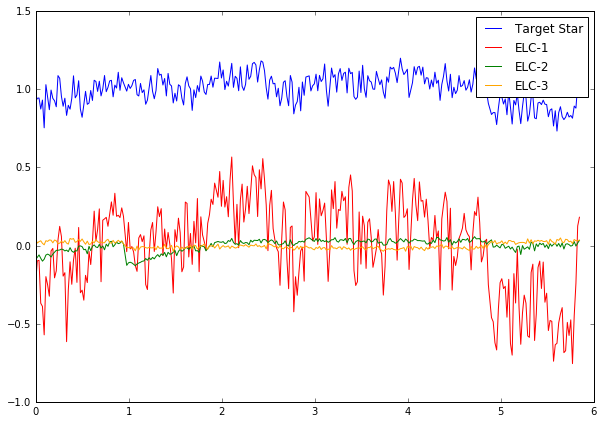

In [493]:
plt.figure(figsize=(10,7)) 
plt.plot(data[:,0],data[:,1],color='b',label='Target Star')
plt.plot(data[:,0],data[:,2],color='r',label='ELC-1')
plt.plot(data[:,0],data[:,3],color='g',label='ELC-2')
plt.plot(data[:,0],data[:,4],color='orange',label='ELC-3')
plt.legend()
plt.show()

## Our Model (cosine + PCA)

In [494]:
def model(pars,data):
    "Our Model"
    
    #Fitted Model parameters
    a=pars[0]       #amplitude of cosine (relative flux)
    p=pars[1]       #period of cosine (hours)
    phi=pars[2]     #phase offset (radians)
    bk=np.zeros(3)  #ELC scales
    bk[0]=pars[3]     #ELC-1
    bk[1]=pars[4]     #ELC-2
    bk[2]=pars[5]     #ELC=3
    mean=pars[6]    #Mean (zero point offset)
    
    #Fixed Model parameters
    #p=4.7 #period of cosine (days)
    tpi=2.0*np.pi #two-pi
    
    m=a*np.cos(tpi/p*data[:,0]+phi)
    for i in range(len(bk)):
        m=m+bk[i]*data[:,i+2]
    m=m+mean
    
    return m;

## our likelihood model for uncorrelated noise

In [495]:
def loglikelihood(func,pars,data):
    "log-likeihood function"
    
    #The next two are part of the noise-model (see the log-likelihood function)
    sig=pars[7]     #point-to-point scatter
    
    m=func(pars,data) #get model
    n=len(data[:,1])
    if n < 1:
        ll=-1.0e30  #set bad value for no data.
    else:
        ll=-0.5*(n*np.log(2*np.pi)+n*(np.log(sig*sig))\
         +sum((m-data[:,1])*(m-data[:,1])/(sig*sig)))
    
    return ll;
    

## Our likelihood for correlated noise

In [496]:
def loglikelihood2(func,pars,data):
    "log-likelihood function"
    
    global kernel
    global logdK
    global oldpars
    
    #The next two are part of the noise-model (see the log-likelihood function)
    sig=pars[7]     #point-to-point scatter
    c=pars[8]       #correlated noise amplitude
    
    l=3.0 #correlation length (days)
    
    n=len(data[:,1])  #number of data points
    m=func(pars,data) #get model
    r=m-data[:,1]     #residuals
    
    #only update the Kernel if we have to.
    #print(oldpars[6],pars[6],oldpars[7],pars[7])
    if oldpars[7] != pars[7] or oldpars[8] != pars[8]:
        #make kernel
        #print('new kernel')
        kernel=np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                kernel[i,j]=c*c*np.exp(-(data[i,0]-data[i,0])/(l*l))
                if i == j:
                    kernel[i,j] = kernel[i,j] + sig*sig
    
        #Cholesky factorization
        kernel=dpotrf(kernel)
        #print(kernel[0])
        logdK=0.0
        for i in range(n):
            logdK=logdK+np.log(kernel[0][i,i])
        
    #solve for K**-1 * r
    ymr=dpotrs(kernel[0],r)
    
    if n < 1:
        ll=-1.0e30  #set bad value for no data.
    else:
        ll=-0.5*(sum(r*ymr[0])+2.0*logdK+n*np.log(2*np.pi))
        #ll=-0.5*(sum(r*ymr[0])+n*np.log(2*np.pi) )
    
    oldpars=np.copy(pars)
    
    return ll;
    

## Our Prior

In [497]:
def lprior(pars):
    "Simple prior with log(pr)=0 with valid parameters, otherwise return large small value"
        
    badlpr=-1.0e30    #bad lpr value
    lpr=0.0           #default return value
    
    if pars[0] < 0: #we want a positive amplitude
        lpr=badlpr
        
    if pars[1] > 10:  #Keep period between 0 and 10 hours
        lpr=badlpr
    if pars[1] < 0:
        lpr=badlpr
        
    if pars[2] > 2*np.pi:  #Keep phi betwee 0 and 2*pi
        lpr=badlpr
    if pars[2] < 0:
        lpr=badlpr
        
    if pars[3] > 10:  #broad priors for Bk
        lpr=badlpr
    if pars[3] < -10:
        lpr=badlpr
    if pars[4] > 10:
        lpr=badlpr
    if pars[4] < -10:
        lpr=badlpr
    if pars[5] > 10:
        lpr=badlpr
    if pars[5] < -10:
        lpr=badlpr
        
    if pars[6] > 10:  #broad prior on mean
        lpr=badlpr
    if pars[6] < -10:
        lpr=badlpr
        
    if pars[7] > 10:  #point-to-point scatter - must be positive
        lpr=badlpr
    if pars[7] < 0:
        lpr=badlpr
    
    #this last parameter is only used for the correlated noise model
    if len(pars) > 8:
        if pars[8] > 10:  #correlated noise amplitude - must be positive
            lpr=badlpr
        if pars[8] < 0:
            lpr=badlpr
        
        
    return lpr;

## Initial Guess for Parameters and get beta for MCMC

In [498]:
#       A  period  ph  b1    b2   b3   mean   sig   
#       0    1     2   3     4     5    6      7    
label=['A','Per','phi','B1','B2','B3','mean','sig']
colour=['r','yellow','b','g','purple','brown','black','orange']
pars=[0.021, 5.854, 1.806, 0.301,-0.215,-0.080, 1.000, 0.041]
#pars=[0.021, 5.854, 1.806, 0.301,-0.215,-0.080, 0.000, 0.041]
beta=[0.005, 0.500, 0.400, 0.100, 0.100, 0.100, 0.005, 0.010]
niter=2000    #number of chains to generate for testing acceptance rates
burnin=200
corscale=mcmc.betarescale(pars,data,beta,niter,burnin,model,loglikelihood,lprior,mcmc.mhgmcmc,imax=40)
betanew=beta*corscale #apply our new beta
print(betanew)

Final Acceptance:  [ 0.25225225  0.25868726  0.24782609  0.22608696  0.22594142  0.22596154
  0.27699531  0.22608696]
[ 0.01217128  0.8242018   0.82085155  0.03349687  0.38978134  0.52542552
  0.01067071  0.00913657]


Use Metropolis-Hastings to create a buffer for DEMCMC

In [499]:
betanew=beta*corscale #apply our new beta
nbuffer=10000 #Size of our deMCMC buffer
burnin=500   #burn-in for M-H-G
niter=nbuffer+burnin 
chain,accept=mcmc.genchain(pars,data,betanew,niter,model,loglikelihood,lprior,mcmc.mhgmcmc)
buffer=np.copy(chain[burnin:,:])

Generate Chains with DEMCMC

In [500]:
corbeta=1.0 #scale for correlated jumps
parin=buffer[nbuffer-1,:] #we can start with the last state from our buffer.
niter=50000
chain,accept=mcmc.genchain(parin,data,betanew,niter,model,loglikelihood,lprior,mcmc.demhmcmc,\
 buffer=buffer,corbeta=corbeta)

Generate Final Chains

In [501]:
buffer=np.copy(chain)
nbuffer=len(buffer[:,0])
corbeta=0.5 #scale for correlated jumps
parin=buffer[nbuffer-1,:] #we can start with the last state from our buffer.
niter=50000
chain,accept=mcmc.genchain(parin,data,betanew,niter,model,loglikelihood,lprior,mcmc.demhmcmc,\
 buffer=buffer,corbeta=corbeta)
chain2,accept=mcmc.genchain(parin,data,betanew,niter,model,loglikelihood,lprior,mcmc.demhmcmc,\
 buffer=buffer,corbeta=corbeta)
chain3,accept=mcmc.genchain(parin,data,betanew,niter,model,loglikelihood,lprior,mcmc.demhmcmc,\
 buffer=buffer,corbeta=corbeta)

## Examine Chains

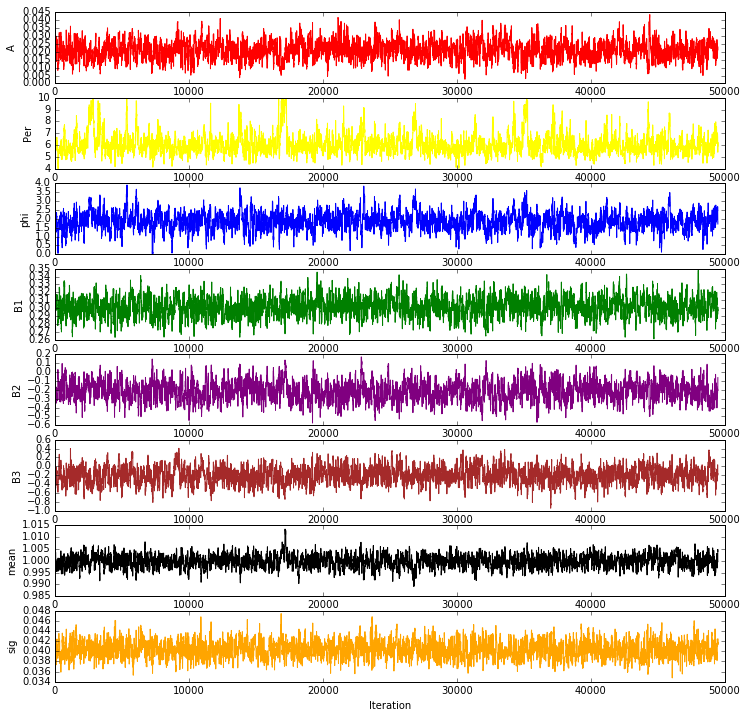

In [502]:
mcmc.plotchains(chain,label,colour,burnin)

## Calculate Confidence Intervals

In [503]:
npars=len(chain[1,:])
mm=np.zeros(npars)
for i in range(0,npars):
    perc = np.percentile(chain[burnin:,i],[0.3, 50.0, 99.7])
    mm[i]=perc[1]
    print('%s = %.3f +%.3f %.3f (3 Sigma)' %(label[i],perc[1],perc[2]-perc[1],perc[0]-perc[1]) )

A = 0.021 +0.017 -0.015 (3 Sigma)
Per = 5.921 +3.932 -1.518 (3 Sigma)
phi = 1.862 +1.484 -1.467 (3 Sigma)
B1 = 0.301 +0.033 -0.033 (3 Sigma)
B2 = -0.218 +0.304 -0.280 (3 Sigma)
B3 = -0.197 +0.513 -0.518 (3 Sigma)
mean = 1.000 +0.007 -0.008 (3 Sigma)
sig = 0.040 +0.005 -0.004 (3 Sigma)


## Overlay model chains with raw data

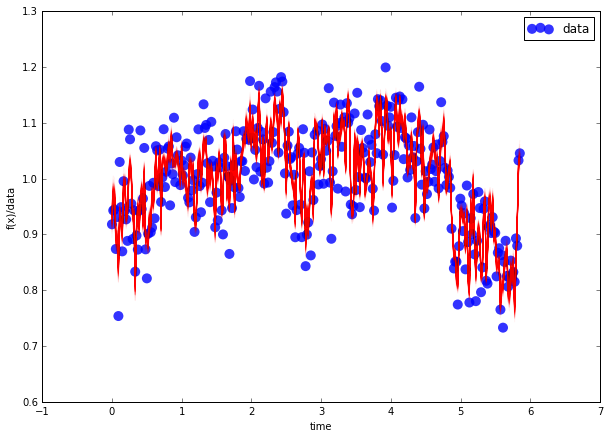

In [504]:
mcmc.plotmodels(data,chain,model,burnin)

## Show cosine component ontop of ELC corrected lightcurve (median values adopted)

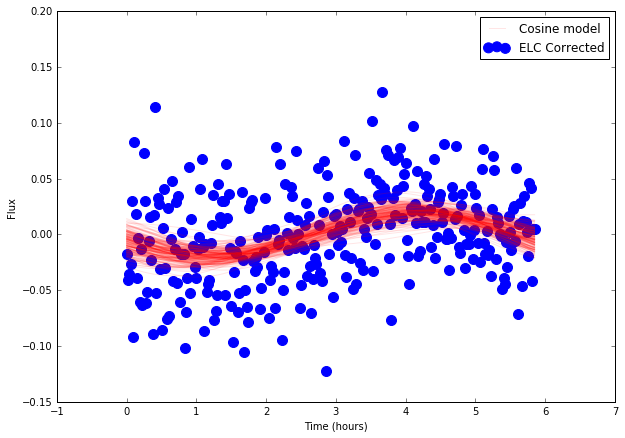

In [505]:
plt.figure(figsize=(10,7)) 
tpars=np.copy(mm)
tpars[0]=0.0
mtest=model(tpars,data)
res=data[:,1]-mtest
plt.scatter(data[:,0],res,s=100.0,color='b',label='ELC Corrected')
plt.xlabel('Time (hours)')
plt.ylabel('Flux')

chainlen=len(chain[:,0])
for i in range(0,200): 
    nchain=int(np.random.rand()*(chainlen-burnin)+burnin) 
    tpars=np.copy(chain[nchain,:])
    tpars[3:7]=0
    mtest=model(tpars,data)
    plt.plot(data[:,0],mtest,color='r',alpha=0.1)

plt.plot(data[:,0],mtest,color='r',alpha=0.1,label='Cosine model')
plt.legend()
plt.show()

## Check convergence Tests

In [506]:
npt=len(data[:,0]) #length of data set is need to get degrees of freedom
grtest=mcmc.gelmanrubin(chain,chain2,chain3,burnin=burnin,npt=npt)
print('Gelman-Rubin Convergence:')
print('parameter  Rc')
for i in range(0,len(chain[1,:])):
    print('%8s  %.3f' %(label[i],grtest[i]))

Gelman-Rubin Convergence:
parameter  Rc
       A  1.004
     Per  1.005
     phi  1.004
      B1  1.003
      B2  1.004
      B3  1.005
    mean  1.003
     sig  1.004


Acceptance rates

In [507]:
mcmc.calcacrate(accept,burnin,label)

Global Acceptance Rate: 0.288
A Acceptance Rate 0.307
Per Acceptance Rate 0.363
phi Acceptance Rate 0.230
B1 Acceptance Rate 0.287
B2 Acceptance Rate 0.191
B3 Acceptance Rate 0.253
mean Acceptance Rate 0.251
sig Acceptance Rate 0.221
deMCMC Acceptance Rate 0.314


## Triangle Plot

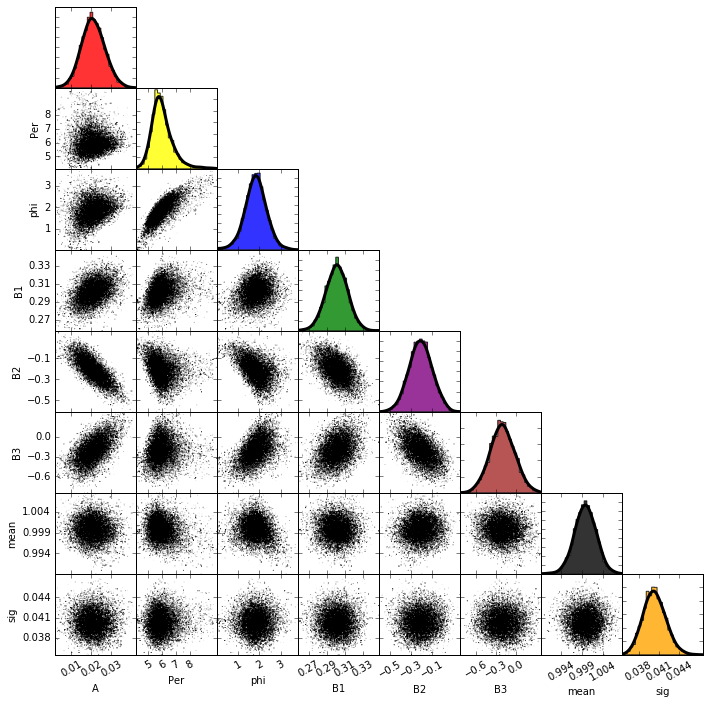

In [508]:
nbin=30
mcmc.triplot(chain2,burnin,label,colour,nbin,ntick=4)

In [509]:
pars1=np.copy(mm)
ll1=loglikelihood(model,pars1,data)
print(ll1)
pars2=np.copy(mm)
pars2[0]=0
ll2=loglikelihood(model,pars2,data)
print(ll2)
print(ll1-ll2)

563.99940152
542.30697704
21.6924244796
